# Invariant and equivariant graph neural networks

## 1. Familiarize yourself with the "tetris" graph dataset

The "tetris" graph dataset contains 7 graphs, which correspond to the seven pieces in the game Tetris. Each graph contains 4 nodes, and the graphs directed and fully connected. The nodes in the dataset have associated 2-d coordinates.

1. Run the code below to load and display the dataset
1. Examine the object 'data', and look at its properties to make sure you understand exactly how the graph data is represented. Note that most properties are stored in torch.Tensor objects.
    1. `num_graphs` Contains the number of graphs in the dataset
    1. `num_nodes` Total number of nodes
    1. `edge_list` List of edges, containing (node_from, node_to)
    1. `node_graph_index` List of which graph number each node belongs to
    1. `node_coordinates` 2-d coordinates for position of each node
    1. `edge_lengths` The length of each edge (distance between the node pair)
    1. `edge_vectors` Vector between the node pair for each edge
1. The function `data.rotate` rotates the coordinates of the nodes for each graph around its center. Try it out to see what happens.
1. Change the code to shift all the graphs coordinates 1 unit to the right on the x-axis (modify the `node_coordinates` property).
    

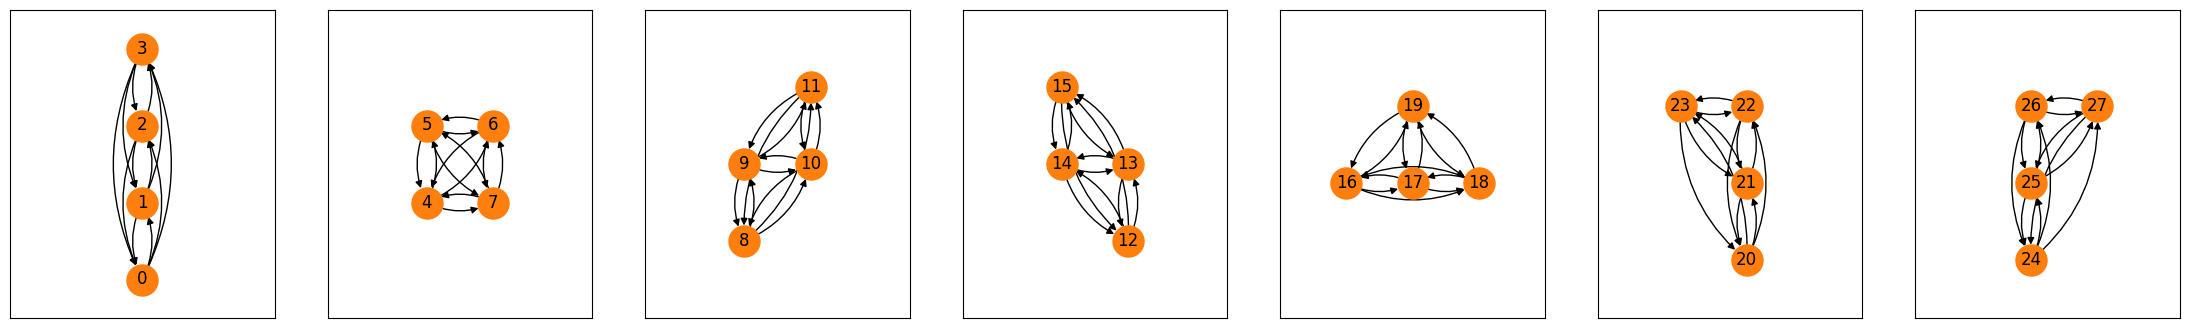

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import Datasets

# Create dataset, center and rotate
data = Datasets.Tetris()
data.center().rotate(0)

# Plot the dataset
fig, ax = plt.subplots(1, data.num_graphs, figsize=(28,4))
for i in range(data.num_graphs):
    ax[i].axis([-2, 2, -2, 2])
    edges = data.edge_list[data.edge_graph_index == i].tolist()
    nodes = np.arange(data.num_nodes)[data.node_graph_index == i]
    
    G = nx.DiGraph()
    G.add_edges_from(edges)
    pos = dict(zip(nodes, data.node_coordinates[nodes].tolist()))
    nx.draw_networkx(G, pos=pos, ax=ax[i], node_size=500, node_color='tab:orange', connectionstyle='arc3,rad=.25')


## 2. Fit a graph neural network to the dataset
1. Run the code below to fit an invariant graph neural network classifier to the "tetris" data
    1. Examine the code and see how works. The network aims at classifying each of the 7 graphs as a separate class, and it minimizes the cross-entropy using the Adam optimizer.
    1. Notice how the loss decreases and accuracy increases as the network trains
1. Run the second code cell below to plot the softmax'ed output of the neural network classifier
    1. Notice that the accuracy does not reach 100%. The neural network cannot distinguish certain graphs. Discuss why this is the case.
1. Examine the implementation of the **GNNInvariant** graph neural network in the file GNNModels.py **(Make sure you understand this completely)**
    1. Notice how the node states are defined and initialized
    1. See what goes into the neural network that is used to compute the messages, and how the message neural network is defined
    1. Notice how the messages are added together for each receiving node.
    1. The code uses the shorthand variables `node_to` and `node_from` - how do they relate to the `edge_list`?
    1. See how the final graph state is computed by combining the node states for all nodes in the graph
    1. See how the final graph state is used to compute the output of the neural network.
1. Run the third code cell below to plot the raw output of the neural network classifier 
1. Run the fourth code cell below to plot the graph nodes with a bar plot inset that shows the node states.
    1. Try rotating and/or translating the dataset and look at the classification result again (without retraining the neural network). Does the output and/or the node states change?
    Hint, for example insert the code `output = net(data.rotate(0.5))` before the plot code to rotate by 0.5 radians.
    1. Experiment with changing different things such as
        1. The dimensionality of the node states (`state_dim`)
        1. The number of message passing rounds (figure out how to change this)
        1. Number of training epochs and learning rate


In [11]:
import torch
from tqdm.notebook import tqdm, trange
from GNNModels import GNNInvariant, GNNEquivariant
import matplotlib.pyplot as plt

# Network, loss function, and optimizer
net = GNNInvariant(output_dim=data.num_graphs, state_dim = 5)
#net = GNNEquivariant(output_dim=data.num_graphs, state_dim = 5)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

epochs = 1000
with trange(epochs) as t:
    for epoch in t:
        optimizer.zero_grad()
        output = net(data)
        loss = loss_function(output, data.graph_list)
        loss.backward()
        optimizer.step()

        accuracy = (torch.argmax(output, 1) == data.graph_list).sum() / data.num_graphs
        t.set_description_str(\
             f'Loss: {loss.detach().numpy():.3f}, \
               Accuracy: {accuracy*100:.0f}%, Progress')


  0%|          | 0/1000 [00:00<?, ?it/s]

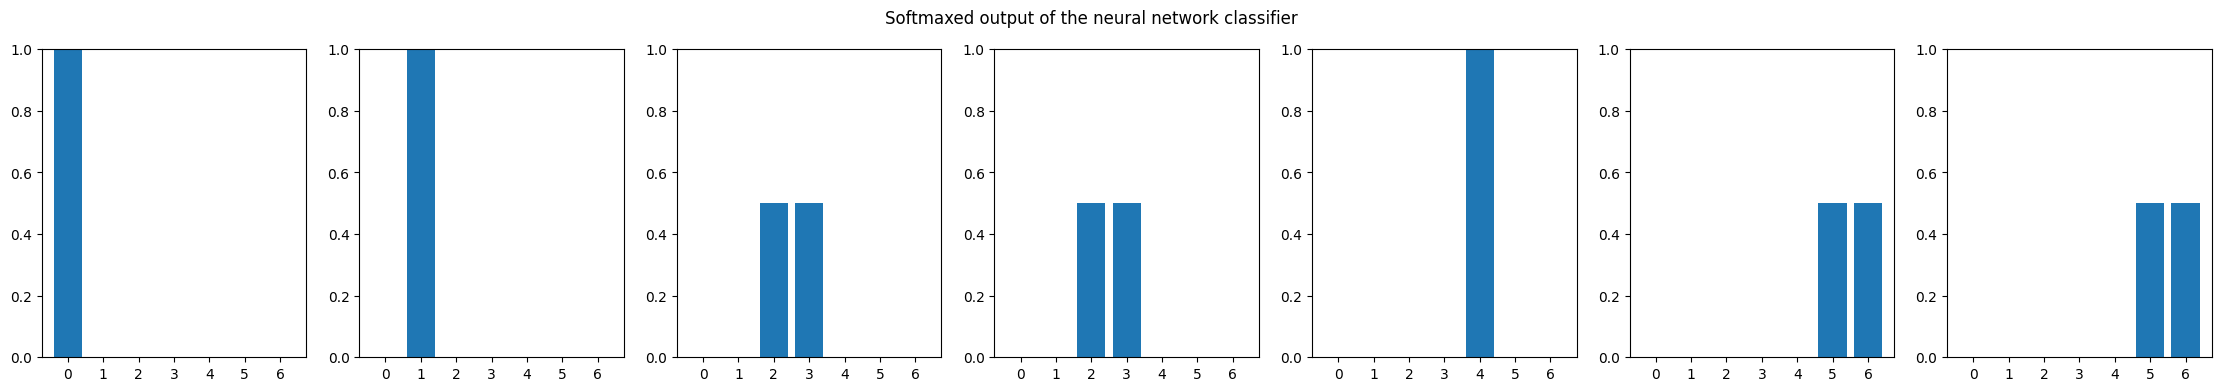

In [8]:
fig, ax = plt.subplots(1, data.num_graphs, figsize=(28,4))
fig.suptitle('Softmax''ed output of the neural network classifier')
for i in range(data.num_graphs):
    ax[i].bar(range(data.num_graphs), torch.nn.functional.softmax(output[i], dim=0).tolist())
    ax[i].set_xticks(range(data.num_graphs))
    ax[i].set_ylim([0, 1])

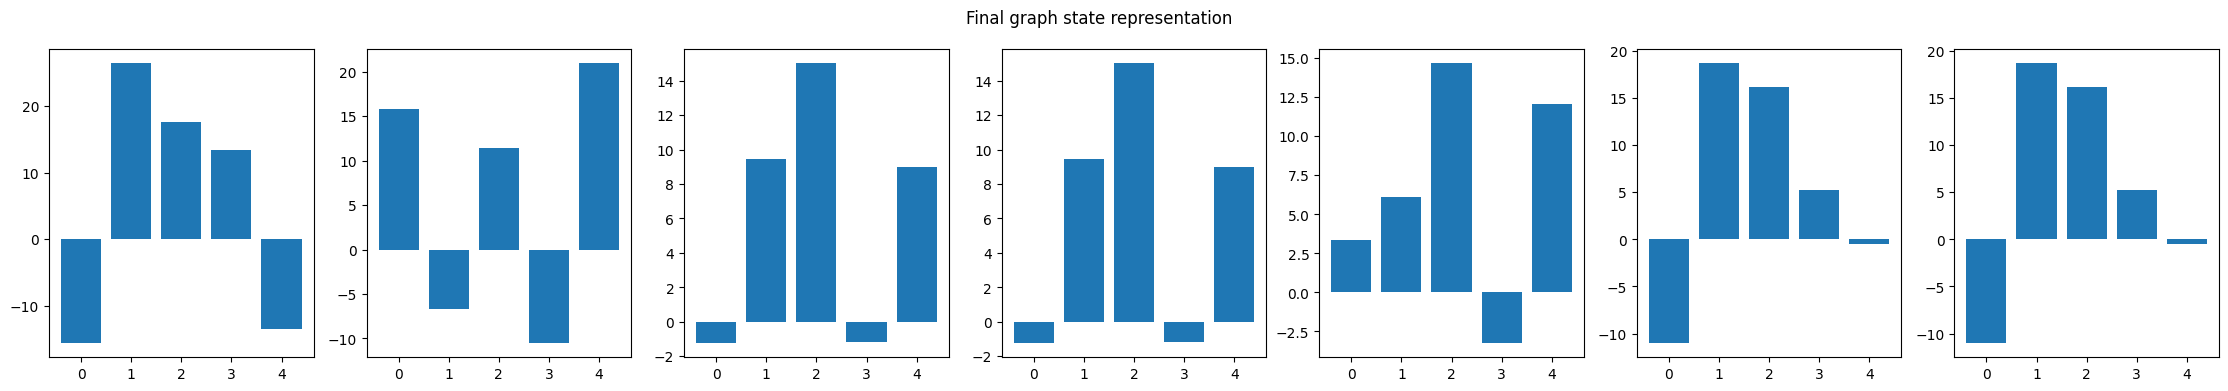

In [9]:
fig, ax = plt.subplots(1, data.num_graphs, figsize=(28,4))
fig.suptitle('Final graph state representation')
for i in range(data.num_graphs):
    ax[i].bar(range(net.state_dim), net.graph_state[i].detach())
    ax[i].set_xticks(range(net.state_dim))

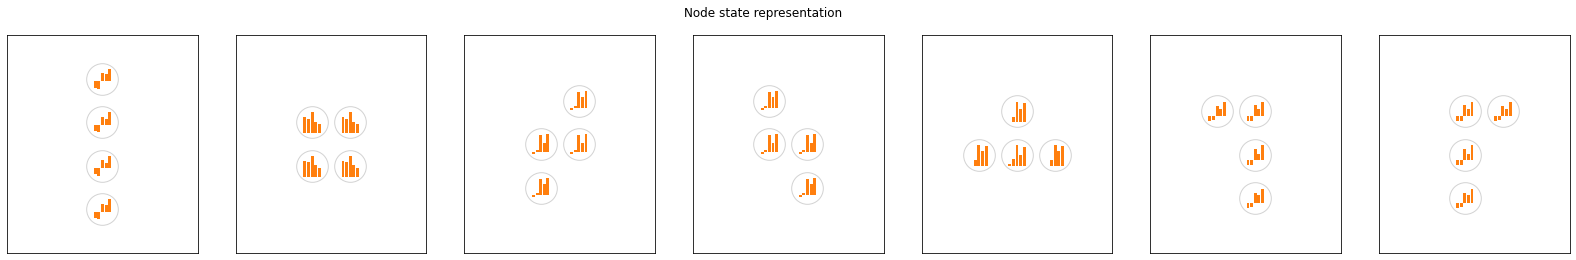

In [22]:
fig, ax = plt.subplots(1, data.num_graphs, figsize=(28,4))
fig.suptitle('Node state representation')
for i in range(data.num_graphs):
    ax[i].axis([-2.5, 2.5, -2.5, 2.5])
    edges = data.edge_list[data.edge_graph_index == i].tolist()
    nodes = np.arange(data.num_nodes)[data.node_graph_index == i]

    G = nx.DiGraph()
    G.add_edges_from(edges)
    pos = dict(zip(nodes, data.node_coordinates[nodes].tolist()))
    nx.draw_networkx_nodes(G, pos=pos, ax=ax[i], node_size=1000, node_color='white', edgecolors='lightgrey')
    ins_size = 0.1
    for j in (data.node_graph_index==i).nonzero().flatten().tolist():
        node_coordinate = data.node_coordinates[j].tolist()
        node_coordinate_axes = ax[i].transAxes.inverted().transform(ax[i].transData.transform(node_coordinate))
        state = net.state[j]
        # Plot node states as barplot insets
        ins = ax[i].inset_axes([node_coordinate_axes[0]-ins_size/2, node_coordinate_axes[1]-ins_size/2, ins_size, ins_size])
        ins.bar(range(net.state_dim), state.tolist(), color='tab:orange')
        ins.set_axis_off()
        # Plot node vector states as arrows
        if isinstance(net, GNNEquivariant):
            for k in range(net.state_dim):
                state_vec = (0.5*torch.nn.functional.normalize(net.state_vec[j,:,k], dim=0)).tolist()
                ax[i].arrow(*node_coordinate, *state_vec, color='tab:blue', head_width=0.1)                



## 3. Fit an equivariant graph neural network to the dataset
1. Change the code above to use the equivariant graph neural network`GNNEquivariant` 
1. Examine the implementation of the **GNNEquivariant** graph neural network in the file GNNModels.py **(Make sure you understand this completely)**
    1. Notice how the node vector states are defined and initialized
    1. See how the dot and cross product are used to compute the messages for the scalar node state.
    1. Examine the message for the node vector state update
1. Use the plot code from the previous exercise to examine the output, final graph representation, and the node scalar and vector states.
    1. Try rotating the dataset and look at the classification result again (without retraining the neural network). Does the output and/or the node states change?
    1. In particular, how do the node vector states change?
    1. Some of the nodes have identical states. Which ones and why?
1. Experiment with changing different things such as
    1. The dimensionality of the node states (`state_dim`). With how small dimensionality can you achieve 100% accuracy. Does this require training for more epochs?
    1. The number of message passing rounds. How many message passing rounds is necessary to reach 100% accuracy?
    1. Number of training epochs and learning rate


## 4. Extra
1. Try the 'Circles' dataset. 
    1. All edge lengths in the graphs are the same, so the scalar node representations cannot distinguish nodes in any of the graphs (verify this). But the GNNInvariant classifier still works - why?